In [1]:
import matplotlib.pyplot as plt
import numpy as np
import quantecon as qe
import pandas as pd
%matplotlib inline

## Partial Default

#### ECON 8701 HW2
#### Hasan Cetin

[Github Link](https://github.com/hamecetin/QuantEcon)

--- 

$$
V(z, a)=\max _{a^{\prime}, d \in[0,1]} u\left(z\left(1-\gamma_0 d^{\gamma_1}\right)-a(1-d)+q\left(a^{\prime}, z\right)\left[a^{\prime}-R \kappa d a\right]\right)+\beta E V\left(z^{\prime}, a^{\prime}\right)
$$
The first order condition for $d$ gives
$$
d=\left(\frac{\left(1-R \kappa q\left(a^{\prime}, z\right)\right) a}{z \gamma_0 \gamma_1}\right)^{\frac{1}{\gamma_1-1}}
$$

Sketch of Algorithm
1. Set up grids for $a=[0,0.5 \bar{z}]$.

2. Start with a guess of $q\left(a^{\prime}, z\right)=1 / R$ and $V\left(z^{\prime}, a^{\prime}\right)=u\left(z^{\prime}\right) /(1-\beta)$

3. Evaluate default decision $d\left(z, a, a^{\prime}\right)$ given (3) and guess $q\left(a^{\prime}, z\right)$. Clamp it to be bounded between 0 and 1 .

4. Maximize the objective by choosing $a^{\prime}$ given $q\left(a^{\prime}, z\right), V\left(z^{\prime}, a^{\prime}\right), d\left(z, a, a^{\prime}\right)$
$$
V(z, a)=\max _{a^{\prime}} u\left(z\left(1-\gamma_0 d^{\gamma_1}\right)-a\left(1-d\left(z, a, a^{\prime}\right)\right)+q\left(a^{\prime}, z\right)\left[a^{\prime}-R \kappa d\left(z, a, a^{\prime}\right) a\right]\right)+\beta E V\left(z^{\prime}, a^{\prime}\right)
$$

5. Recover decision rule decision rule $\mathbf{a}^{\prime}(z, a)$ that results from the maximization.
6. Update price function using by applying the decision rule $a^{\prime}(z, a)$ such that $\mathbf{d}(z, a)=d\left(z, a, \mathbf{a}^{\prime}(z, a)\right)$ and
$$
q\left(a^{\prime}, z\right)=\frac{1}{R} \mathbb{E}(\left(1-\mathbf{d}(z, a)+R \kappa \mathbf{d}(z, a) q\left(\mathbf{a}^{\prime \prime}\left(z^{\prime}, a^{\prime}\right), z^{\prime}\right)\right))
$$
7. Check for convergence of the value function and the price function. Go back to step 3, and continue until convergence.

In [2]:
β=0.954
γ_0=[0.05, 0.15, 0.5]
γ_1=2
R=1.04 
ρ=0.875
σ=0.0052 
κ=0.7
σ_utility = 2

a_grid_size=90
z_grid_size= 5
a_min=0

tol = 10e-5
dist = 10e5
iteration = 0
max_iteration = 10e5

In [3]:
#Income grid and Transition matrix
Markov = qe.markov.tauchen(ρ, σ , 0, 3, z_grid_size)
Π = Markov.P   #Transition probability
z_grid = np.exp(Markov.state_values) #z_grid

In [4]:
#Debt grid
a_max = 1/2 * np.max(z_grid)
a_grid = np.linspace(a_min,a_max,a_grid_size)  #a grid

In [5]:
np.mean(z_grid)

1.0002596030927233

In [ ]:
debt_policies_indices = []
debt_policies = []
default_policies = []
value_functions = []
prices = []
iterations = []
distances = []

for gamma in γ_0:
    print("\n gamma_0 is: ", gamma, "\n")

    #Initializing price and value functions
    V_p = np.ones((z_grid_size, a_grid_size))
    for i in range(np.shape(V_p)[0]):
        V_p[i,:] = (z_grid[i]**(1-σ_utility)/(1-σ_utility) )  /(1-β)


    V_row = np.ones(a_grid_size)

    V = np.zeros((z_grid_size, a_grid_size)) # Value function

    def_pol = np.zeros((z_grid_size, a_grid_size, a_grid_size)) #default policy

    d_hat = np.empty_like(V_p) #default policy given prices

    q = np.ones((z_grid_size, a_grid_size))* (1/R) #Initial guess for prices
    q_p = q.copy()

    a_policy = np.zeros((z_grid_size, a_grid_size)) #To store optimal policy function
    a_policy_index = np.zeros((z_grid_size, a_grid_size))

    while dist > tol and iteration < max_iteration:
        for i_z in range(z_grid_size):
            z = z_grid[i_z]
            for i_a in range(a_grid_size):
                a = a_grid[i_a]
                for i_a_p in range(a_grid_size):
                    a_p = a_grid[i_a_p]

                    def_val = (((1 - (R * κ * q[i_z,i_a_p]))* a)/(z * gamma * γ_1))**(1/(γ_1 - 1))
                    if def_val >= 1:
                        d = 1
                    elif def_val <= 0:
                        d = 0
                    else:
                        d = def_val
                    
                    c = z*(1-gamma* (d **γ_1)) - a*(1-d) + q[i_z, i_a_p] * (a_p - R*κ*d*a)

                    if c <= 0:
                        util = -10e3
                    else:
                        util = (c ** (1 - σ_utility)) / (1 - σ_utility)
                    
                    V_row[i_a_p] = util + β * np.dot(Π[i_z,:], V_p[:, i_a_p])     
        
                V[i_z,i_a] = np.nanmax(V_row)
                a_policy_index[i_z,i_a] = np.nanargmax(V_row)
                a_policy[i_z,i_a] = a_grid[int(a_policy_index[i_z,i_a])]
            
                def_val = (((1 - (R * κ * q[i_z,int(a_policy_index[i_z,i_a])]))* a_grid[i_a])/(z_grid[i_z] * gamma * γ_1))**(1/(γ_1 - 1))
                if def_val >= 1:
                    d = 1
                elif def_val <= 0:
                    d = 0
                else:
                    d = def_val

                d_hat[i_z,i_a] = d

        for i_a_p in range(a_grid_size): 
            q_p_p = np.array([q[0, int(a_policy_index[0, i_a_p])], q[1, int(a_policy_index[1, i_a_p])], q[2, int(a_policy_index[2, i_a_p])], q[3, int(a_policy_index[3, i_a_p])], q[4, int(a_policy_index[4, i_a_p])]])
            for i_z in range(z_grid_size):
                z = z_grid[i_z]
            
                q_p[i_z,i_a_p] = (1/R) * np.matmul(Π[i_z, :].T, (1 - d_hat[:, i_a_p]) + R * κ * d_hat[:, i_a_p] * q_p_p)

        dist1 = np.max(np.abs(V-V_p))
        dist2 = np.max(np.abs(q-q_p))
        dist = np.max((dist1,dist2))

        q= q_p.copy()
        V_p = V.copy()

        iteration += 1

        if iteration % 50 == 0:
            print("iteration: ", iteration)
            print("dist: ", dist)

    debt_policies_indices.append(a_policy_index)
    debt_policies.append(a_policy)
    default_policies.append(d_hat)
    value_functions.append(V)
    prices.append(q)
    iterations.append(iteration)
    distances.append(dist)

    dist = 10e10
    iteration = 0


 gamma_0 is:  0.05 

iteration:  50
dist:  0.0019066660073931985
iteration:  100
dist:  0.00017786052215384984

 gamma_0 is:  0.15 

iteration:  50
dist:  0.0020796123102293507
iteration:  100
dist:  0.00019520035265330193

 gamma_0 is:  0.5 

iteration:  50
dist:  0.0022430682595953044
iteration:  100
dist:  0.0002513633280365468


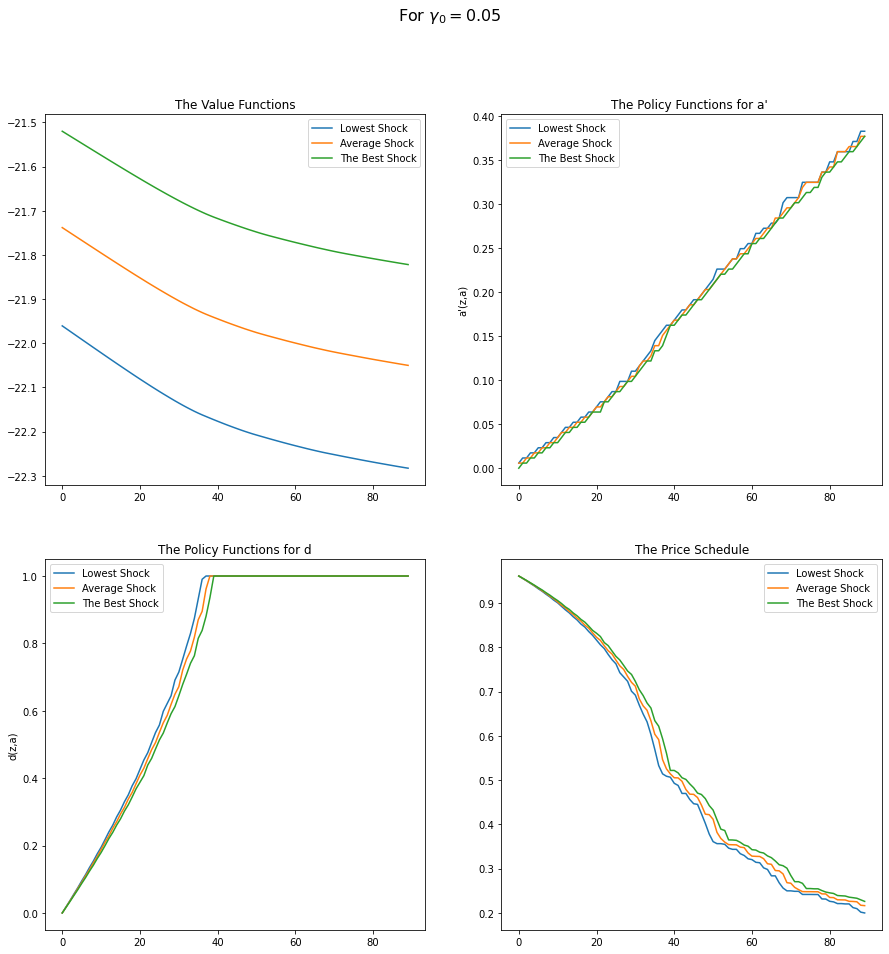

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
name_list = ["Lowest Shock", 1,"Average Shock",  2,"The Best Shock"]
for i in [0,z_grid_size//2,-1]:
    fig.suptitle("For $\gamma_0 = 0.05$", fontsize=16 )
    ax[0,0].plot(value_functions[0][i,:], label = name_list[i])
    ax[0,0].set_title("The Value Functions")
    ax[0,0].legend()

    ax[0,1].plot(debt_policies[0][i,:],label=name_list[i])
    ax[0,1].set_title("The Policy Functions for a' ")
    ax[0,1].set_ylabel("a'(z,a)")
    ax[0,1].legend()

    ax[1,0].plot(default_policies[0][i,:],label=name_list[i])
    ax[1,0].set_title("The Policy Functions for d")
    ax[1,0].set_ylabel("d(z,a)")
    ax[1,0].legend()

    ax[1,1].plot(prices[0][i,:],label=name_list[i])
    ax[1,1].set_title("The Price Schedule")
    ax[1,1].legend()


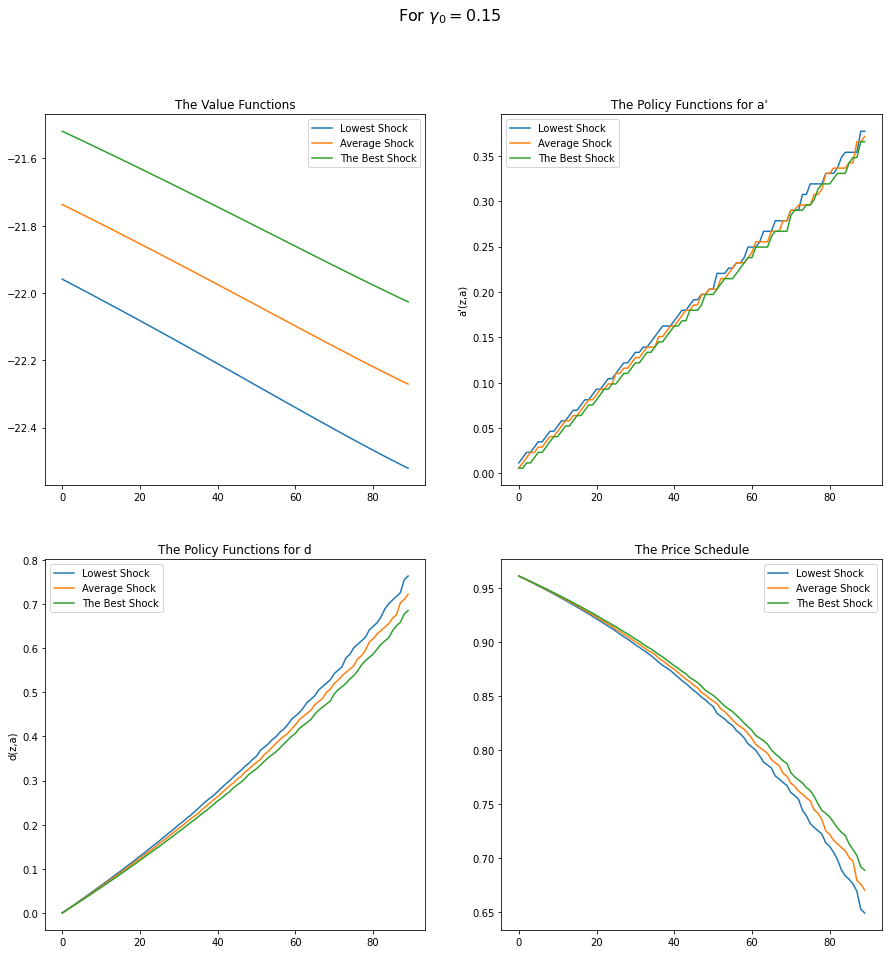

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
name_list = ["Lowest Shock", 1,"Average Shock",  2,"The Best Shock"]
for i in [0,2,4]:
    fig.suptitle("For $\gamma_0 = 0.15$", fontsize=16 )
    ax[0,0].plot(value_functions[1][i,:], label = name_list[i])
    ax[0,0].set_title("The Value Functions")
    ax[0,0].legend()

    ax[0,1].plot(debt_policies[1][i,:],label=name_list[i])
    ax[0,1].set_title("The Policy Functions for a' ")
    ax[0,1].set_ylabel("a'(z,a)")
    ax[0,1].legend()

    ax[1,0].plot(default_policies[1][i,:],label=name_list[i])
    ax[1,0].set_title("The Policy Functions for d")
    ax[1,0].set_ylabel("d(z,a)")
    ax[1,0].legend()

    ax[1,1].plot(prices[1][i,:],label=name_list[i])
    ax[1,1].set_title("The Price Schedule")
    ax[1,1].legend()

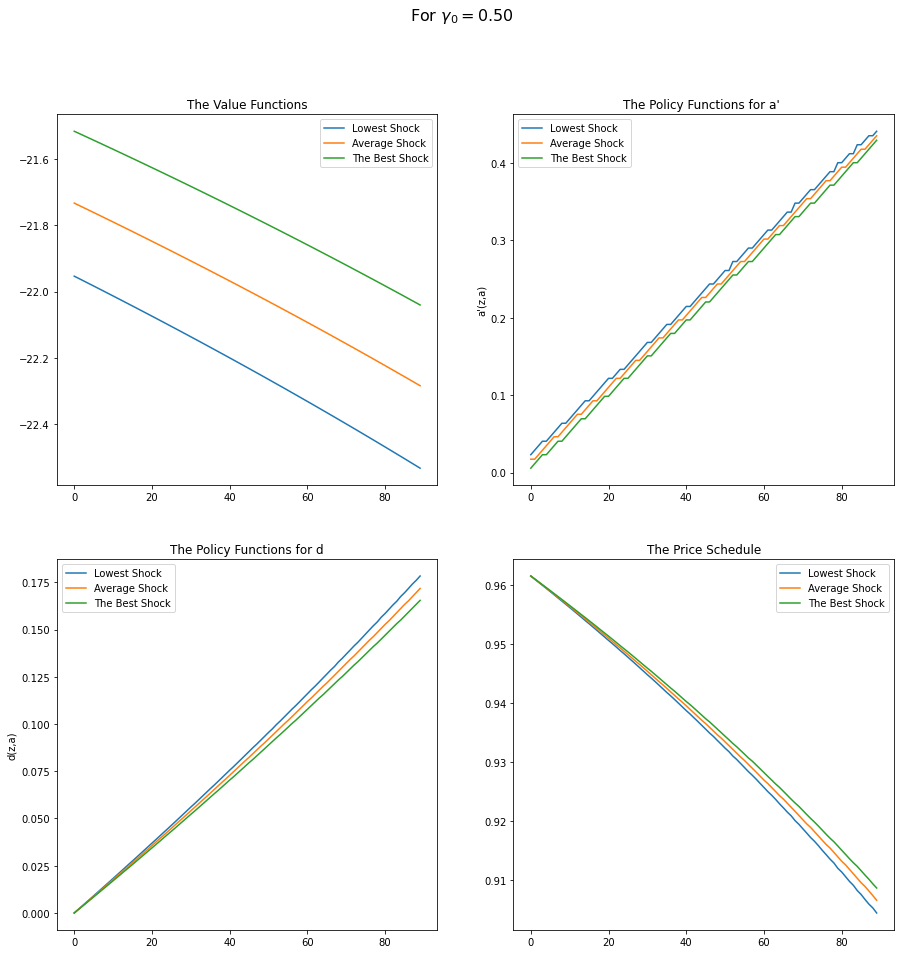

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
name_list = ["Lowest Shock", 1,"Average Shock",  2,"The Best Shock"]
for i in [0,2,4]:
    fig.suptitle("For $\gamma_0 = 0.50$", fontsize=16 )
    ax[0,0].plot(value_functions[2][i,:], label = name_list[i])
    ax[0,0].set_title("The Value Functions")
    ax[0,0].legend()

    ax[0,1].plot(debt_policies[2][i,:],label=name_list[i])
    ax[0,1].set_title("The Policy Functions for a' ")
    ax[0,1].set_ylabel("a'(z,a)")
    ax[0,1].legend()

    ax[1,0].plot(default_policies[2][i,:],label=name_list[i])
    ax[1,0].set_title("The Policy Functions for d")
    ax[1,0].set_ylabel("d(z,a)")
    ax[1,0].legend()

    ax[1,1].plot(prices[2][i,:],label=name_list[i])
    ax[1,1].set_title("The Price Schedule")
    ax[1,1].legend()

## Simulation

Let's first simulate the income shocks:

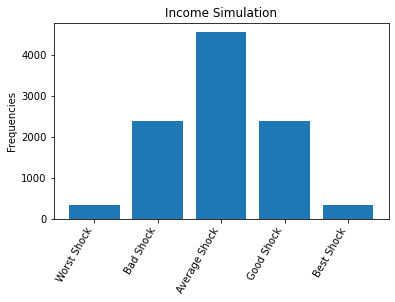

In [ ]:
T = 10000 #Time period

#Simulation of income shocks
mc = qe.MarkovChain(Π, z_grid)
z_sim_indices = mc.simulate_indices(T, init = np.searchsorted(z_grid, np.mean(z_grid)))  #We assumed that 
                                                                    #the simulation started from the middle shock


frequencies = [np.sum(z_sim_indices == 0),np.sum(z_sim_indices == 1),np.sum(z_sim_indices == 2),np.sum(z_sim_indices == 3),np.sum(z_sim_indices == 4)]
shocks = ["Worst Shock","Bad Shock","Average Shock","Good Shock","Best Shock"]

fig,ax = plt.subplots()
fig.autofmt_xdate(rotation=60)
ax.bar(shocks, frequencies)
ax.set_title("Income Simulation")
ax.set_ylabel("Frequencies")

plt.show()

In [ ]:
a_sim_indices = [np.zeros(T),np.zeros(T),np.zeros(T)]
a_sim = [np.zeros(T),np.zeros(T),np.zeros(T)]
d_sim = [np.zeros(T-1),np.zeros(T-1),np.zeros(T-1)]
y_sim = [np.zeros(T),np.zeros(T),np.zeros(T)]


#Starting with debt
a_sim_indices[0][0] = 0
a_sim_indices[1][0] = 0
a_sim_indices[2][0] = 0

a_sim[0][0] = a_grid[0]
a_sim[1][0] = a_grid[0]
a_sim[2][0] = a_grid[0]

t = 0

In [ ]:
a_sim_indices[2]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
for i in range(3):
    t = 0
    while t < T-1:
        a_idx = int(a_sim_indices[i][t])
        z_idx = int(z_sim_indices[t])

        d_sim[i][t] = default_policies[i][z_idx, a_idx]
        a_sim_indices[i][t+1] = debt_policies_indices[i][z_idx, a_idx]
        a_sim[i][t+1] = a_grid[int(a_sim_indices[i][t+1])]

        y_sim[i][t] = z_grid[z_idx] * (1- γ_0[i] * (d_sim[i][t]**(γ_1)))
        t = t + 1

In [ ]:
#Default Simulations
default_times_l = np.sum(d_sim[0] != 0)
default_times_m = np.sum(d_sim[1] != 0)
default_times_h = np.sum(d_sim[2] != 0)

d_mean_l = np.mean(d_sim[0][2000:])
d_max_l = np.max(d_sim[0][2000:])
d_min_l = np.min(d_sim[0][2000:])
d_std_l = np.std(d_sim[0][2000:])

d_mean_m = np.mean(d_sim[1][2000:])
d_max_m = np.max(d_sim[1][2000:])
d_min_m = np.min(d_sim[1][2000:])
d_std_m = np.std(d_sim[1][2000:])

d_mean_h = np.mean(d_sim[2][2000:])
d_max_h = np.max(d_sim[2][2000:])
d_min_h = np.min(d_sim[2][2000:])
d_std_h = np.std(d_sim[2][2000:])

default_low = {"γ_0 ":γ_0[0], "default mean": d_mean_l, "default max":d_max_l, "default min": d_min_l, "default std":d_std_l, "default phase": default_times_l/T}
default_middle = {"γ_0 ":γ_0[1], "default mean": d_mean_m, "default max":d_max_m, "default min": d_min_m, "default std":d_std_m, "default phase": default_times_m/T}
default_high = {"γ_0 ":γ_0[2], "default mean": d_mean_h, "default max":d_max_h, "default min": d_min_h, "default std":d_std_h, "default phase": default_times_h/T}


#Debt Simulations
a_mean_l = np.mean(a_sim[0][2000:])
a_max_l = np.max(a_sim[0][2000:])
a_min_l = np.min(a_sim[0][2000:])
a_std_l = np.std(a_sim[0][2000:])

a_mean_m = np.mean(a_sim[1][2000:])
a_max_m = np.max(a_sim[1][2000:])
a_min_m = np.min(a_sim[1][2000:])
a_std_m = np.std(a_sim[1][2000:])

a_mean_h = np.mean(a_sim[2][2000:])
a_max_h = np.max(a_sim[2][2000:])
a_min_h = np.min(a_sim[2][2000:])
a_std_h = np.std(a_sim[2][2000:])

debt_low = {"γ_0 ":γ_0[0], "debt mean": a_mean_l, "debt max":a_max_l, "debt min": a_min_l, "debt std":a_std_l}
debt_middle = {"γ_0 ":γ_0[1], "debt mean": a_mean_m, "debt max":a_max_m, "debt min": a_min_m, "debt std":a_std_m}
debt_high = {"γ_0 ":γ_0[2], "debt mean": a_mean_h, "debt max":a_max_h, "debt min": a_min_h, "debt std":a_std_h}

#Income Simulations
y_mean_l = np.mean(y_sim[0][2000:-1])
y_max_l = np.max(y_sim[0][2000:-1])
y_min_l = np.min(y_sim[0][2000:-1])
y_std_l = np.std(y_sim[0][2000:-1])

y_mean_m = np.mean(y_sim[1][2000:-1])
y_max_m = np.max(y_sim[1][2000:-1])
y_min_m = np.min(y_sim[1][2000:-1])
y_std_m = np.std(y_sim[1][2000:-1])

y_mean_h = np.mean(y_sim[2][2000:-1])
y_max_h = np.max(y_sim[2][2000:-1])
y_min_h = np.min(y_sim[2][2000:-1])
y_std_h = np.std(y_sim[2][2000:-1])

income_low = {"γ_0 ":γ_0[0], "income mean": y_mean_l, "income max": y_max_l, "income min": y_min_l, "income std":y_std_l}
income_middle = {"γ_0 ":γ_0[1], "income mean": y_mean_m, "income max":y_max_m, "income min": y_min_m, "income std":y_std_m}
income_high = {"γ_0 ":γ_0[2], "income mean": y_mean_h, "income max":y_max_h, "income min": y_min_h, "income std":y_std_h}

income_list = [income_low, income_middle, income_high]
debt_list = [debt_low, debt_middle, debt_high]
default_list = [default_low, default_middle, default_high]

df_income = pd.DataFrame(income_list)
df_debt = pd.DataFrame(debt_list)
df_default = pd.DataFrame(default_list)

In [ ]:
df_income

,γ_0,income mean,income max,income min,income std
0,0.05,0.999783,1.032733,0.968224,0.013861
1,0.15,0.999714,1.032728,0.968093,0.013877
2,0.50,0.999481,1.032675,0.967562,0.013950


In [ ]:
df_debt

,γ_0,debt mean,debt max,debt min,debt std
0,0.05,0.008646,0.011604,0.005802,0.002900
1,0.15,0.025628,0.034812,0.011604,0.005461
2,0.50,0.083632,0.121841,0.040614,0.016346


In [ ]:
df_default

,γ_0,default mean,default max,default min,default std,default phase
0,0.05,0.026579,0.036901,0.017058,0.009283,0.9998
1,0.15,0.026197,0.036901,0.011326,0.005898,0.9998
2,0.50,0.025631,0.038799,0.011897,0.005365,0.9998


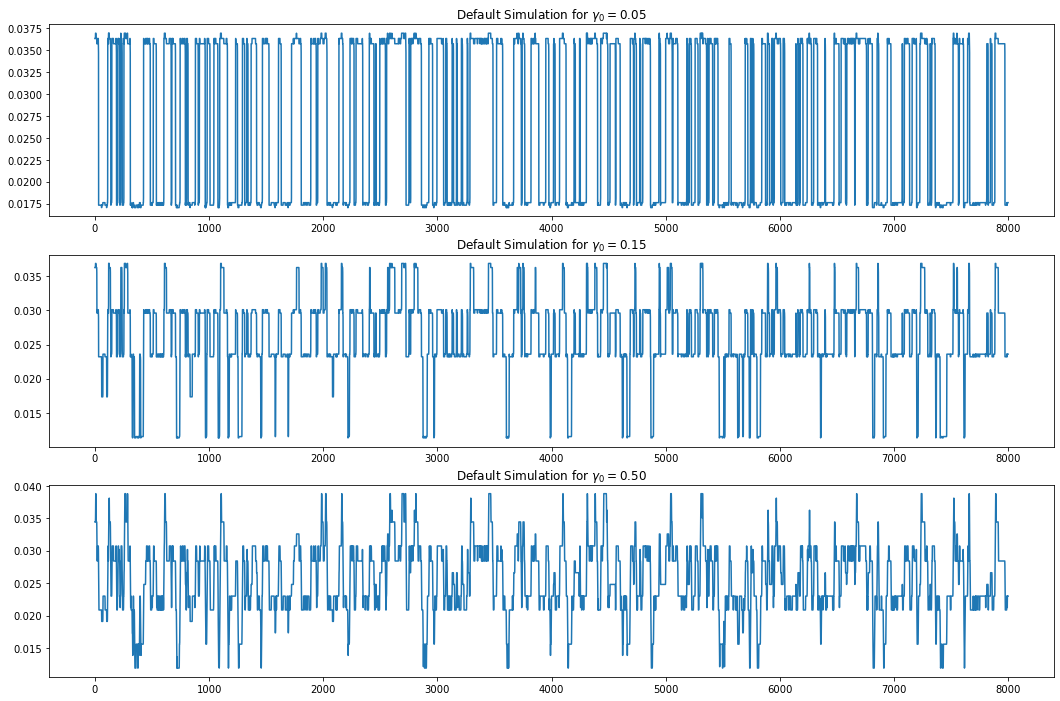

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(18,12))

ax[0].plot(d_sim[0][2000:])
ax[0].set_title("Default Simulation for $\gamma_0 = 0.05$")
ax[1].plot(d_sim[1][2000:])
ax[1].set_title("Default Simulation for $\gamma_0 = 0.15$")
ax[2].plot(d_sim[2][2000:])
ax[2].set_title("Default Simulation for $\gamma_0 = 0.50$")
plt.show()

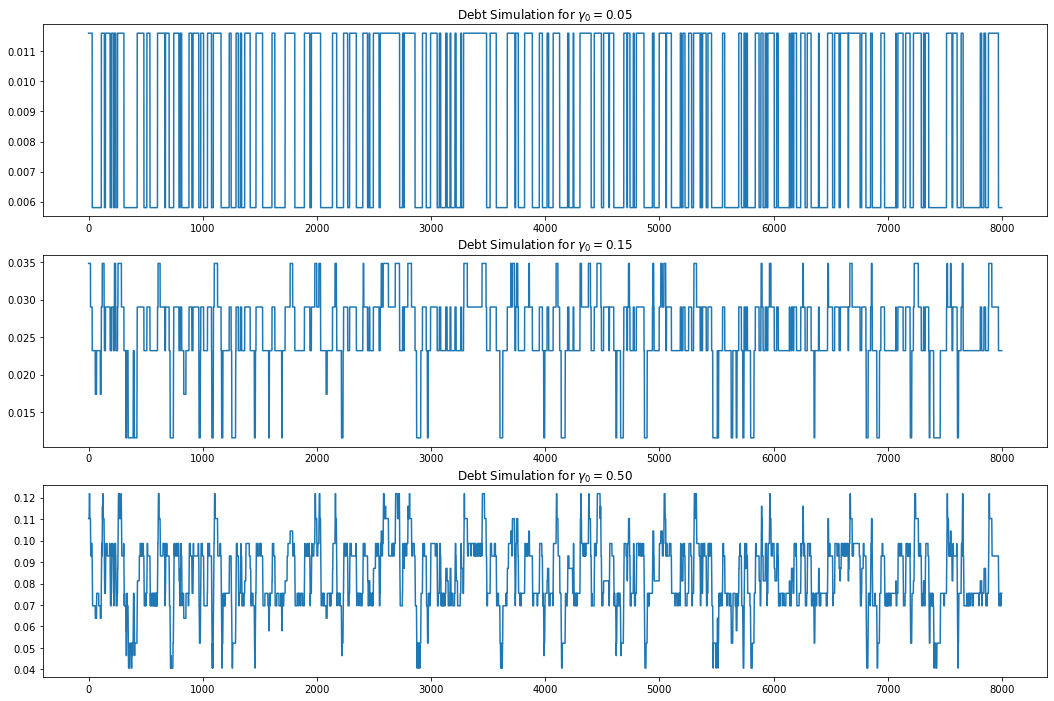

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(18,12))

ax[0].plot(a_sim[0][2000:])
ax[0].set_title("Debt Simulation for $\gamma_0 = 0.05$")
ax[1].plot(a_sim[1][2000:])
ax[1].set_title("Debt Simulation for $\gamma_0 = 0.15$")
ax[2].plot(a_sim[2][2000:])
ax[2].set_title("Debt Simulation for $\gamma_0 = 0.50$")
plt.show()

## Discussion

First of all, we can see from the value function graphs that the value function is decreasing over the debt holding. I did three cases: Small, average and big default income punishments (by changing $\gamma_0$). And for lower income punishment, government finds it optimal to fully default on higher debts. That makes the price of bonds decrease a lot on high debt levels (for low income punishment case). The default and bond demand is increasing in debts as well, i.e. if government has higher debt levels, he wants to default more and borrow more.

Let's try to explain the simulation results. I start the simulation from 0 debt, and for graphs and tables, I ignored first 2000 simulations. We see from graphs that the partial default rate oscillates around 2.6% and debt holding oscillates around 1% for low income punishment case. As I increase the income punishment, partial default mean decreases and debt holding increases. The reason of partial default decrease is easy to understand: because it is now more costly. But why do we see higher debt rates? My intuition is that there are two ways for the government to smooth his consumption and finance his consumption: 1) Borrow to repay tomorrow; 2) Partial default on your debt today. When partial default becomes more costly, the borrowing option become more attractive for the government and that's why we see the increase in demand for borrowing. One interesting result is that most of the time, the government stays in the "default" zone.

The main issue of this model is having low debt/GDP ratio. We can increase this by making the default more costly but then if we try to match the debt/GDP ratio with the data, we will have so high default rate that the partial default become much lower. 

## Empirics and accounting of Default Episodes

In [233]:
df = pd.read_csv('Monetary_Dataset_Clean.csv')

df["def episode"] = (df['Defaulted Coupons'] > 0) * 1
df['part_def'] = df["Defaulted Coupons"]/ (df["Debt service"] + df["Defaulted Coupons"])
df["Debt to GDP"] = df["Debt"]/ df["NomOutput"]


In [234]:
df

,Country Name,Country Code,YEAR,RealGDP,NomOutput,lnGDP,Output,Debt,Debt service,Defaulted Coupons,def episode,part_def,Debt to GDP
0,Argentina,ARG,1970,2.207342e+11,3.158421e+10,26.120225,0.067683,1.963191e+09,4.724232e+08,0.0,0,0.0,0.062157
1,Argentina,ARG,1971,2.332236e+11,3.329320e+10,26.175264,0.100623,2.256904e+09,4.427635e+08,0.0,0,0.0,0.067789
2,Argentina,ARG,1972,2.370215e+11,3.473300e+10,26.191417,0.094677,2.498891e+09,4.874138e+08,0.0,0,0.0,0.071946
3,Argentina,ARG,1973,2.436859e+11,5.254400e+10,26.219146,0.100307,2.938708e+09,6.784529e+08,0.0,0,0.0,0.055929
4,Argentina,ARG,1974,2.571710e+11,7.243678e+10,26.273007,0.132069,3.421164e+09,8.108323e+08,0.0,0,0.0,0.047230
...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,South Africa,ZAF,2017,3.530553e+11,3.814488e+11,26.589890,-0.023732,9.062512e+10,5.532512e+09,0.0,0,0.0,0.237581
418,South Africa,ZAF,2018,3.584299e+11,4.041597e+11,26.604999,-0.034287,8.866308e+10,1.570064e+10,0.0,0,0.0,0.219376
419,South Africa,ZAF,2019,3.595176e+11,3.885320e+11,26.608029,-0.056921,1.020509e+11,7.673262e+09,0.0,0,0.0,0.262658
420,South Africa,ZAF,2020,3.367153e+11,3.376197e+11,26.542504,-0.148110,9.942968e+10,1.111146e+10,0.0,0,0.0,0.294502


In [235]:
print("The mean of partial defaults conditional on default: ", df[df["part_def"] > 0]["part_def"].mean())

The mean of partial defaults conditional on default:  0.20383028076088514


In [236]:
print("The frequency of partial defaults: ", df["def episode"].sum()/421)

The frequency of partial defaults:  0.5534441805225653


In [250]:
df["def episode"].sum()

233

In [237]:
import itertools

#Mean Default Episodes
Mean_def_years = []
for i in df["Country Code"].unique():
    Data = df[df["Country Code"] == i]
    Episode = Data["def episode"]
    Def_mean = np.array([(len(list(y))) for x, y in itertools.groupby(Episode) if x == 1]).mean() #Mean Default episodes for each country
    Mean_def_years.append(Def_mean) #Making a list

Mean_def = np.array(Mean_def_years).mean() #Mean of mean default episodes

Mean_def  

13.675925925925926

In [238]:
Mean_def_years

[13.0, 23.0, 24.0, 21.5, 7.333333333333333, 2.25, 9.0, 21.0, 2.0]

In [239]:
Before_Indices = {}
Beginning_Indices = {}
Middle_Indices = {}
After_Indices = {}

beginning_list = []



for i in df["Country Code"].unique():
    Data = df[df["Country Code"] == i]
    Episode = Data["def episode"]

    beginning_list = []
    if Episode.iloc[0] == 1:
        beginning_list.append(Episode.index[0])

    beginning = np.array(beginning_list + list( Episode.diff()[Episode.diff() == 1].index.values)) #Beginning the default episode indices

    if Episode.iloc[0] == 1:
        before = (beginning - 1)[1:]
    else:    
        before = beginning - 1                                      #Before the default episode indices
    
    after = Episode.diff()[Episode.diff() == -1].index.values    #After the default episode indices
    
    pseudo_after = list(after)                                   #After the default episode indices for countries which still defaults at the end
    if Episode[Episode.index[-1]] == 1:
        pseudo_after.append(Episode.index[-1] + 1)

    mid = (beginning + pseudo_after) // 2                        #Middle of the default episode indices

    Before_Indices[i] = list(before)
    Beginning_Indices[i] = list(beginning)
    Middle_Indices[i] = list(mid)
    After_Indices[i] = list(after)
    print(i, "DONE!")
    

ARG DONE!
BRA DONE!
COL DONE!
ECU DONE!
IDN DONE!
MEX DONE!
PHL DONE!
RUS DONE!
ZAF DONE!


In [240]:
x = np.array([0,1,1,2,4])

x.shape[0]

5

In [241]:
Before_Indices

{'ARG': [10, 12, 29],
 'BRA': [98],
 'COL': [113],
 'ECU': [157, 165],
 'IDN': [222, 234],
 'MEX': [265, 267, 270, 277],
 'PHL': [317, 339, 346],
 'RUS': [],
 'ZAF': [403]}

In [242]:
Beginning_Indices

{'ARG': [11, 13, 30],
 'BRA': [52, 99],
 'COL': [114],
 'ECU': [158, 166],
 'IDN': [208, 223, 235],
 'MEX': [266, 268, 271, 278],
 'PHL': [318, 340, 347],
 'RUS': [364],
 'ZAF': [404]}

In [243]:
Middle_Indices

{'ARG': [11, 21, 41],
 'BRA': [74, 99],
 'COL': [126],
 'ECU': [158, 187],
 'IDN': [210, 227, 239],
 'MEX': [266, 269, 273, 279],
 'PHL': [326, 343, 349],
 'RUS': [374],
 'ZAF': [405]}

In [244]:
After_Indices

{'ARG': [12, 29],
 'BRA': [97, 100],
 'COL': [138],
 'ECU': [159],
 'IDN': [212, 232, 244],
 'MEX': [267, 270, 275, 280],
 'PHL': [335, 346, 351],
 'RUS': [385],
 'ZAF': [406]}

In [245]:
Before_Partdef = {}
Before_Output = {}
Before_Debt = {}


for k,v in Before_Indices.items():
    Before_Partdef[k] = df.iloc[v]["part_def"].mean()
    Before_Output[k] = df.iloc[v]["Output"].mean()
    Before_Debt[k] = df.iloc[v]["Debt to GDP"].mean()

Before_Partdef, Before_Output, Before_Debt


before_part_def = np.nanmean(np.array(list(Before_Partdef.values())))
before_output = np.nanmean(np.array(list(Before_Output.values())))
before_debt = np.nanmean(np.array(list(Before_Debt.values())))

before_part_def, before_output, before_debt

(0.0, 0.03316412986482964, 0.18338242516123832)

In [246]:
Beginning_Partdef = {}
Beginning_Output = {}
Beginning_Debt = {}


for k,v in Beginning_Indices.items():
    Beginning_Partdef[k] = df.iloc[v]["part_def"].mean()
    Beginning_Output[k] = df.iloc[v]["Output"].mean()
    Beginning_Debt[k] = df.iloc[v]["Debt to GDP"].mean()

beginning_part_def = np.nanmean(np.array(list(Beginning_Partdef.values())))
beginning_output = np.nanmean(np.array(list(Beginning_Output.values())))
beginning_debt = np.nanmean(np.array(list(Beginning_Debt.values())))

beginning_part_def, beginning_output, beginning_debt

(0.1333830793376952, 0.03900835201306163, 0.1806026053411025)

In [247]:
Middle_Partdef = {}
Middle_Output = {}
Middle_Debt = {}


for k,v in Middle_Indices.items():
    Middle_Partdef[k] = df.iloc[v]["part_def"].mean()
    Middle_Output[k] = df.iloc[v]["Output"].mean()
    Middle_Debt[k] = df.iloc[v]["Debt to GDP"].mean()

middle_part_def = np.nanmean(np.array(list(Middle_Partdef.values())))
middle_output = np.nanmean(np.array(list(Middle_Output.values())))
middle_debt = np.nanmean(np.array(list(Middle_Debt.values())))

middle_part_def, middle_output, middle_debt

(0.19489400368995968, -0.012787632926519433, 0.2517211126272533)

In [248]:
After_Partdef = {}
After_Output = {}
After_Debt = {}


for k,v in After_Indices.items():
    After_Partdef[k] = df.iloc[v]["part_def"].mean()
    After_Output[k] = df.iloc[v]["Output"].mean()
    After_Debt[k] = df.iloc[v]["Debt to GDP"].mean()

after_part_def = np.nanmean(np.array(list(After_Partdef.values())))
after_output = np.nanmean(np.array(list(After_Output.values())))
after_debt = np.nanmean(np.array(list(After_Debt.values())))

after_part_def, after_output, after_debt

(0.0, 0.00337349463679657, 0.19195520285935966)

In [249]:
table = pd.DataFrame({"Timeline": ["Before", "Beginning", "Middle", "After"],"Partial Default": [before_part_def,beginning_part_def,middle_part_def, after_part_def], \
            "Output": [before_output,beginning_output,middle_output,after_output],\
            "Debt": [before_debt,beginning_debt,middle_debt,after_debt]}).set_index("Timeline")

table

,Partial Default,Output,Debt
Timeline,,,
Before,0.000000,0.033164,0.183382
Beginning,0.133383,0.039008,0.180603
Middle,0.194894,-0.012788,0.251721
After,0.000000,0.003373,0.191955


In [223]:
df["part_def"].max()

0.5234841818061673

In [252]:
df[df["Country Code"] == "RUS"]["def episode"]

364    1
365    1
366    1
367    1
368    1
369    1
370    1
371    1
372    1
373    1
374    1
375    1
376    1
377    1
378    1
379    1
380    1
381    1
382    1
383    1
384    1
385    0
386    0
387    0
388    0
389    0
390    0
391    0
392    0
393    0
Name: def episode, dtype: int64

In [259]:
df[df["Country Code"] == "RUS"]

,Country Name,Country Code,YEAR,RealGDP,NomOutput,lnGDP,Output,Debt,Debt service,Defaulted Coupons,def episode,part_def,Debt to GDP
364,Russian Federation,RUS,1992,9.426095e+11,4.602906e+11,27.571918,0.138827,6.457130e+10,1.358414e+09,1.099729e+10,1,0.890058,0.140284
365,Russian Federation,RUS,1993,8.608990e+11,4.350837e+11,27.481243,0.027871,1.017011e+11,2.103737e+09,9.863442e+09,1,0.824208,0.233751
366,Russian Federation,RUS,1994,7.526861e+11,3.950773e+11,27.346914,-0.126740,1.083017e+11,3.294589e+09,1.889153e+10,1,0.851502,0.274128
367,Russian Federation,RUS,1995,7.214984e+11,3.955372e+11,27.304596,-0.189340,1.020970e+11,5.864184e+09,2.845405e+10,1,0.829123,0.258122
368,Russian Federation,RUS,1996,6.944056e+11,3.917249e+11,27.266322,-0.247895,1.023919e+11,6.323333e+09,3.313186e+10,1,0.839734,0.261387
369,Russian Federation,RUS,1997,7.041267e+11,4.049290e+11,27.280224,-0.254275,1.069376e+11,5.955740e+09,9.386301e+09,1,0.611803,0.264090
370,Russian Federation,RUS,1998,6.668083e+11,2.709555e+11,27.225768,-0.329013,1.192423e+11,7.161403e+09,1.162006e+10,1,0.618698,0.440081
371,Russian Federation,RUS,1999,7.094834e+11,1.959071e+11,27.287803,-0.287260,1.188121e+11,4.248499e+09,1.401076e+10,1,0.767324,0.606472
372,Russian Federation,RUS,2000,7.804322e+11,2.597101e+11,27.383114,-0.212231,9.027042e+10,4.713059e+09,1.189790e+10,1,0.716268,0.347581
373,Russian Federation,RUS,2001,8.202347e+11,3.066021e+11,27.432856,-0.182770,8.529263e+10,9.146893e+09,1.082709e+10,1,0.542060,0.278187
